In [ ]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import train_test_split
import shutil
import random
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.models import Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import scipy
from scipy import ndimage
import tensorflow as tf

In [ ]:
df_label = pd.read_csv("cxr_label_train.csv")

In [ ]:
# train_path = './IML_CXR/'
train_path = '/content/drive/MyDrive/Colab Notebooks/hw3_data/IML_CXR/'
# test_path = './IML_CXR_TEST/'
test_path = '/content/drive/MyDrive/Colab Notebooks/hw3_data/IML_CXR_TEST/'
train_dead_path = './TRAIN/dead/'
train_alive_path = './TRAIN/alive/'
valid_dead_path = './VALID/dead/'
valid_alive_path = './VALID/alive/'
IMG_SIZE = (224,224)

In [ ]:
def cp_image():
    img_train = os.listdir(train_path)
    for img_name in img_train:
        img_path = train_path + img_name
        PatientID = img_name.split('.jpg')
        condition = (df_label["PATIENT ID"] == int(PatientID[0]))
        label = df_label[condition].iloc[0,1] #take image label
        num = random.randint(1,10)
        if label == 0:
            if num <= 2 :
                shutil.copyfile(train_path + img_name, valid_alive_path + img_name)
            else :
                shutil.copyfile(train_path + img_name, train_alive_path + img_name)
        else :
            if num <= 2:
                shutil.copyfile(train_path + img_name, valid_dead_path + img_name)
            else :   
                shutil.copyfile(train_path + img_name, train_dead_path + img_name)

In [ ]:
if (os.path.isdir('./TRAIN')): 
    shutil.rmtree('./TRAIN')
os.mkdir('./TRAIN')
os.mkdir(train_dead_path)
os.mkdir(train_alive_path)
if (os.path.isdir('./VALID')): 
    shutil.rmtree('./VALID')
os.mkdir('./VALID')
os.mkdir(valid_dead_path)
os.mkdir(valid_alive_path)
cp_image()

In [ ]:
test_datagen = image.ImageDataGenerator(
    rescale = 1./255
)
validation_generator = test_datagen.flow_from_directory(
    './VALID',
    target_size=IMG_SIZE, 
    batch_size=8
    # class_mode='binary'
)

train_datagen = image.ImageDataGenerator( 
    rescale = 1./255,
    rotation_range=5,    
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    './TRAIN',
    target_size=IMG_SIZE,
    batch_size=8
)

Found 285 images belonging to 2 classes.
Found 1108 images belonging to 2 classes.


In [ ]:

model = ResNet50(
    input_shape = (IMG_SIZE[0],IMG_SIZE[1],3),
    include_top=False,
    weights="imagenet",
    input_tensor=None,
)
FREEZE_LAYERS = 2
NUM_CLASSES = 2
x = model.output
x = Flatten()(x)
x = Dropout(0.2)(x)
output_layer = Dense(NUM_CLASSES, activation='softmax', name='softmax')(x)

net_final = Model(inputs=model.input, outputs=output_layer)
for layer in net_final.layers[:FREEZE_LAYERS]:
    layer.trainable = False
for layer in net_final.layers[FREEZE_LAYERS:]:
    layer.trainable = True




In [ ]:
sgd = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9, decay=0.005, nesterov=False)
adam = tf.keras.optimizers.Adam(lr=1e-5)
adadelta = tf.keras.optimizers.Adadelta()
net_final.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
net_final.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
139/139 [==============================] - 27s 141ms/step - loss: 0.7053 - accuracy: 0.8098 - val_loss: 0.6306 - val_accuracy: 0.6982
Epoch 2/20
139/139 [==============================] - 18s 131ms/step - loss: 0.6254 - accuracy: 0.8021 - val_loss: 0.9389 - val_accuracy: 0.3228
Epoch 3/20
139/139 [==============================] - 18s 130ms/step - loss: 0.5251 - accuracy: 0.8369 - val_loss: 0.6717 - val_accuracy: 0.6316
Epoch 4/20
139/139 [==============================] - 18s 128ms/step - loss: 0.5481 - accuracy: 0.8471 - val_loss: 0.8767 - val_accuracy: 0.5298
Epoch 5/20
139/139 [==============================] - 18s 129ms/step - loss: 0.4392 - accuracy: 0.8523 - val_loss: 0.8279 - val_accuracy: 0.5895
Epoch 6/20
139/139 [==============================] - 18s 128ms/step - loss: 0.4706 - accuracy: 0.8533 - val_loss: 0.6199 - val_accuracy: 0.7193
Epoch 7/20
139/139 [==============================] - 18s 128ms/step - loss: 0.4554 - accuracy: 0.8535 - val_loss: 0.5947 - val_ac

In [ ]:
X_train = []
Y_train = []

[[0.5207236  0.47927642]]


0

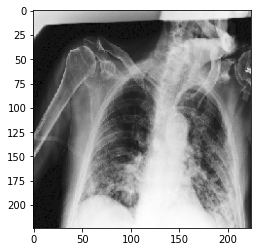

In [ ]:
img_path = train_path + "638.jpg"
img = image.load_img(img_path, target_size=IMG_SIZE)

plt.imshow(img)
img = image.img_to_array(img) / 255.0
img = np.expand_dims(img, axis=0)  

print(net_final.predict(img))
np.argmax(net_final.predict(img))

In [ ]:
from sklearn import metrics
np.set_printoptions(threshold=np.inf)

In [ ]:
prediction = []
answer = []

files = os.listdir(valid_dead_path)
for f in files:
    img = image.load_img(valid_dead_path+f, target_size=IMG_SIZE)
    img = image.img_to_array(img)/ 255.0
    img = np.expand_dims(img, axis=0)
    pred = net_final.predict(img)
    res = np.argmax(pred)
    prediction.append(res)
    answer.append(1)

files = os.listdir(valid_alive_path)
for f in files:
    img = image.load_img(valid_alive_path+f, target_size=IMG_SIZE)
    img = image.img_to_array(img)/ 255.0
    img = np.expand_dims(img, axis=0)
    pred = net_final.predict(img)[0]
    res = np.argmax(pred)
    prediction.append(res)
    answer.append(0)

prediction = np.array(prediction)
answer = np.array(answer)

In [ ]:
print(answer)
print(prediction)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [ ]:
print('Precision:', metrics.precision_score(answer, prediction))
print('Recall:', metrics.recall_score(answer, prediction))
print('F1:', metrics.f1_score(answer, prediction, average = 'macro'))

Precision: 0.4
Recall: 0.125
F1: 0.5630411255411256


In [ ]:
net_final.save('my_model-adam_6.h5')